In [27]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer

In [2]:
#sklearn will return a pandas dataframe insted of a numpy array
random_state = 42
sns.set_style("darkgrid")

# Load Data

In [3]:
nba       = pd.read_csv('../data/nba/nba_salaries.csv')
insurance = pd.read_csv('../data/insurance/insurance.csv')
airline   = pd.read_csv('../data/airline/train.csv')
airbnb    = pd.read_csv('../data/airbnb/listings.csv')

# Skewness

In [ ]:
'''
def correct_skew(df: pd.DataFrame, feature: str, max_power: int = 50,
                 skew_threshold: float = 0.1) :

    df = df.copy()

    #remove nan
    initial_number_rows = len(df)
    df = df.dropna(subset=[feature])
    not_na_rows = len(df)
    print(f'Number of rows removed due to NAN : {initial_number_rows - not_na_rows}')

    df_temp = df.copy()

    #subsample
    if df_temp.memory_usage().sum() > 1000000:
        df_temp = df.sample(frac=round(5000 / df.shape[0], 2))

    skew = df[feature].skew()
    power = 1
    power_step = 0.01
    text_initial_skew = f'Initial Skewness: {round(skew, 4)}'

    skew = abs(skew)
    results = {}

    #Positively skewed feature
    if skew > 0.5:
        # raise feature to 1 / power
        while round(skew, 2) != 0 and power <= max_power:
            power += power_step
            skew = np.power(df[feature], 1/power).skew()
        rounded_power = round(power, 3)
        df_temp[f'{feature}_corrected_raised_(1/{rounded_power})'] = np.power(df_temp[feature], 1/power)   
        text_power_skew = f'Skewness after raising to 1/{rounded_power}: {round(skew, 4)}'
        results['raise_to_power'] = abs(round(skew, 4)) 
        results['power'] = rounded_power

        #log transformation
        df_temp[f'{feature}_corrected_log'] = np.log(df_temp[feature] + 1e-7)
        skew = df_temp[f'{feature}_corrected_log'].skew()
        text_log_skew = f'Skewness after log transformation: {round(skew, 4)}'
        results['log'] = abs(round(skew, 4))

        #Yeo Jhonson transformation
        pwr_transformer = PowerTransformer(method='yeo-johnson')
        df_temp[f'{feature}_corrected_yeo_johnson'] = pwr_transformer.fit_transform(df_temp[feature].values.reshape(-1, 1))
        skew = df_temp[f'{feature}_corrected_yeo_johnson'].skew()
        text_yeo_skew = f'Skewness after Yeo Jhonson transformation: {round(skew, 4)}'
        results['yeo_johnson'] = abs(round(skew, 4))

        #test whether the transformation were successful
        #if the skewness is larger than skew_threshold, then the transformation was not successful
        #and the skewed feature will be converted in a binary feature
        if min(results.values()) > skew_threshold:
            df_temp[f'{feature}_binary'] = np.where(df_temp[feature] == df_temp[feature].min(), 0, 1)
            text_binary_feature = f'{feature} was converted in a binary feature'
            fig, axs = plt.subplots(3, 2, figsize=(15, 12))
            sns.countplot(f'{feature}_binary', ax=axs[2,0])
            axs[2,0].set_title(text_binary_feature)
            fig.delaxes(axs[2, 1])
        else:
            fig, axs = plt.subplots(2, 2, figsize=(15, 12))
            min_key = min(results, key=results.get)
            if min_key == 'raise_to_power':
                df[f'{feature}_corrected_raised_(1/{rounded_power})'] = np.power(df[feature], 1/power)
            elif min_key == 'log':
                df[f'{feature}_corrected_log'] = np.log(df[feature] + 1e-7)
            elif min_key == 'yeo_johnson':
                df[f'{feature}_corrected_yeo_johnson'] = pwr_transformer.fit_transform(df[feature].values.reshape(-1, 1))
            

        sns.histplot(df_temp[feature], ax=axs[0,0], kde=True, stat='density')
        sns.histplot(df_temp[f'{feature}_corrected_raised_(1/{rounded_power})'], ax=axs[0,1], kde=True, stat='density')
        sns.histplot(df_temp[f'{feature}_corrected_log'], ax=axs[1,0], kde=True, stat='density')
        sns.histplot(df_temp[f'{feature}_corrected_yeo_johnson'], ax=axs[1,1], kde=True, stat='density')
        axs[0, 0].set_title(text_initial_skew)
        axs[0,1].set_title(text_power_skew)
        axs[1,0].set_title(text_log_skew)
        axs[1,1].set_title(text_yeo_skew)
        plt.show() 
    
    # Negatively skewed feature
    elif skew < - 0.5:
        # raise feature to power 2
        df_temp[f'{feature}_raised_to_2'] = np.power(df_temp[feature], 2) 
        skew = df_temp[f'{feature}_raised_to_2'].skew()
        results['power_2'] = abs(round(skew, 4))
        text_power_2 = f'Skewness after squared transformation: {round(skew, 4)}'

        # raise feature to power 3
        df_temp[f'{feature}_raised_to_3'] = np.power(df_temp[feature], 3) 
        skew = df_temp[f'{feature}_raised_to_3'].skew()
        results['power_3'] = abs(round(skew, 4))
        text_power_3 = f'Skewness after cubic transformation: {round(skew, 4)}'

        #log transformation
        df_temp[f'{feature}_corrected_log'] = df_temp[feature] + 1 - df_temp[feature].max
        df_temp[f'{feature}_corrected_log'] = np.log(df_temp[f'{feature}_corrected_log'])
        skew = df_temp[f'{feature}_corrected_log'].skew()
        results['log'] = abs(round(skew, 4))
        text_log_skew = f'Skewness after log transformation: {round(skew, 4)}'

        #Yeo Jhonson transformation
        pwr_transformer = PowerTransformer(method='yeo-johnson')
        df_temp[f'{feature}_corrected_yeo_johnson'] = pwr_transformer.fit_transform(df_temp[feature].values.reshape(-1, 1))
        skew = df_temp[f'{feature}_corrected_yeo_johnson'].skew()
        results['yeo'] = abs(round(skew, 4))
        text_yeo_skew = f'Skewness after Yeo Jhonson transformation: {round(skew, 4)}'

        fig, axs = plt.subplots(3, 2, figsize=(15, 12))

        #test whether the transformation were successful
        #if the skewness is larger than skew_threshold.1, then the transformation was not successful
        #and the skewed feature will be converted in a binary feature
        if min(results.values()) > skew_threshold:
            df_temp[f'{feature}_binary'] = np.where(df_temp[feature] == df_temp[feature].max(), 1, 0)
            text_binary_feature = f'{feature} was converted in a binary feature'
            sns.countplot(f'{feature}_binary', ax=axs[2,20])
            axs[2,2].set_title(text_binary_feature)
        
        else:
            fig.delaxes(axs[2, 2])
            min_key = min(results, key=results.get)
            if min_key == 'power_2':
                df[f'{feature}_raised_to_2'] = np.power(df[feature], 2)
            elif min_key == 'power_3':
                df[f'{feature}_raised_to_3'] = np.power(df[feature], 3)
            elif min_key == 'log':
                df[f'{feature}_log_transformed'] = np.log(df[feature] + 1e-7)
            elif min_key == 'yeo_johnson':
                df[f'{feature}_yeo_johnson_transformed'] = pwr_transformer.fit_transform(df[feature].values.reshape(-1, 1))


        
        sns.histplot(df[feature], ax=axs[0,0], kde=True, stat='density')
        sns.histplot(df_temp[f'{feature}_raise_to_2'], ax=axs[0,1], kde=True, stat='density')
        sns.histplot(df_temp[f'{feature}_raise_to_3'], ax=axs[1,0], kde=True, stat='density')
        sns.histplot(df_temp[f'{feature}_corrected_log'], ax=axs[1,1], kde=True, stat='density')
        sns.histplot(df_temp[f'{feature}_corrected_yeo_johnson'], ax=axs[2,1], kde=True, stat='density')

        axs[0, 0].set_title(text_initial_skew)
        axs[0,1].set_title(text_power_2)
        axs[1,0].set_title(text_power_3)
        axs[1,1].set_title(text_log_skew)
        axs[2,1].set_title(text_yeo_skew)
        plt.show()

    return df, results

'''

In [ ]:
def correct_skew(df: pd.DataFrame, feature: str, max_power: int = 50,
                 skew_threshold: float = 0.1) :

    df = df.copy()

    #remove nan
    initial_number_rows = len(df)
    df = df.dropna(subset=[feature])
    not_na_rows = len(df)
    print(f'Number of rows removed due to NAN : {initial_number_rows - not_na_rows}')

    df_temp = df.copy()

    #subsample
    if df_temp.memory_usage().sum() > 1000000:
        df_temp = df.sample(frac=round(5000 / df.shape[0], 2))
    subsampled_number_rows = len(df_temp)
    if subsampled_number_rows == not_na_rows:
        print('It was not necessary to subsample the dataframe')
        subsampled = False #variable to indicate whether the dataframe was subsampled
    else:
        print(f'{not_na_rows - subsampled_number_rows} rows from {not_na_rows} were removed due to subsampling')
        subsampled = True #variable to indicate whether the dataframe was subsampled
    #if the dataframe was subsampled, then the subsampled dataframe will be stored in df_temp. Otherwise, df_temp will be equal to df
    #the subsampled dataframe will be used to plot the histograms, and the original dataframe will be used to store the transformed features

    skew = df[feature].skew()
    text_initial_skew = f'Initial Skewness: {round(skew, 4)}'

    #the dictionary will be used to store the results of the different transformations
    results = {}

    #Positively skewed feature
    if skew > 0.5:
        #positively skewed features will be raised to 1/power
        power = 1
        power_step = 0.01
        #search for the power that makes the skewness close to 0
        while round(skew, 2) != 0 and power <= max_power:
            power += power_step
            skew = np.power(df[feature], 1/power).skew()
        rounded_power = round(power, 3)

        feature_power_name = f'{feature}_raised_to_(1/{rounded_power})' #name of the transformed feature
        df_temp[feature_power_name] = np.power(df_temp[feature], 1/power)   
        text_power_skew = f'Skewness after raising to 1/{rounded_power}: {round(skew, 4)}' #title of the plot
        results[feature_power_name] = abs(round(skew, 4)) 

        #log transformation
        feature_log_name = f'{feature}_log_transformed' #name of the transformed feature
        df_temp[feature_log_name] = np.log(df_temp[feature] + 1e-7)
        skew = df_temp[feature_log_name].skew()
        text_log_skew = f'Skewness after log transformation: {round(skew, 4)}' #title of the plot
        results[feature_log_name] = abs(round(skew, 4))

        #Yeo Jhonson transformation
        feature_yeo_name = f'{feature}_yeo_johnson_transformed' #name of the transformed feature
        pwr_transformer = PowerTransformer(method='yeo-johnson')
        df_temp[feature_yeo_name] = pwr_transformer.fit_transform(df_temp[feature].values.reshape(-1, 1))
        skew = df_temp[feature_yeo_name].skew()
        text_yeo_skew = f'Skewness after Yeo Jhonson transformation: {round(skew, 4)}' #title of the plot
        results[feature_yeo_name] = abs(round(skew, 4))

        #Creating plots
        fig, axs = plt.subplots(3, 2, figsize=(15, 12))
        sns.histplot(df_temp[feature], ax=axs[0,0], kde=True, stat='density')
        sns.histplot(df_temp[feature_power_name], ax=axs[0,1], kde=True, stat='density')
        sns.histplot(df_temp[feature_log_name], ax=axs[1,0], kde=True, stat='density')
        sns.histplot(df_temp[feature_yeo_name], ax=axs[1,1], kde=True, stat='density')
        axs[0, 0].set_title(text_initial_skew)
        axs[0,1].set_title(text_power_skew)
        axs[1,0].set_title(text_log_skew)
        axs[1,1].set_title(text_yeo_skew)

        #test whether the transformation were successful
        #if the skewness is larger than skew_threshold, then the transformation was not successful
        #and the skewed feature will be converted in a binary feature
        if min(results.values()) > skew_threshold:
            print(f'It was not possible to make the {feature} distribution close to normal, therefore if will be converted into a binary feature')
            binary_feature_name = f'{feature}_binary'
            df_temp[binary_feature_name] = np.where(df_temp[feature] == df_temp[feature].min(), 0, 1)
            if subsampled:
                #create the new binary feature in the original dataframe
                df[binary_feature_name] = np.where(df[feature] == df[feature].min(), 0, 1)
            text_binary_feature = f'{feature} was converted in a binary feature' #title of the plot
            sns.countplot(data = df_temp, x = binary_feature_name, ax=axs[2,0])
            axs[2,0].set_title(text_binary_feature)
            fig.delaxes(axs[2, 1])
            plt.tight_layout()
            plt.show()
        else:
            #delete the unnecessary axis
            fig.delaxes(axs[2, 0])
            fig.delaxes(axs[2, 1])
            plt.tight_layout()
            plt.show()
            
            #min_key is the transformation that produced the best results
            min_key = min(results, key=results.get)

            #create the new transformed feature in the original dataframe
            #only the transformed feature that produced the best result will be created
            if subsampled:
                if min_key == feature_power_name:
                    df[feature_power_name] = np.power(df[feature], 1/power)
                elif min_key == feature_log_name:
                    df[feature_log_name] = np.log(df[feature] + 1e-7)
                elif min_key == feature_yeo_name:
                    df[feature_yeo_name] = pwr_transformer.fit_transform(df[feature].values.reshape(-1, 1))
            #if sumsampled is false, then only the transformed feature that produced the best result will be kept in df_temp
            else:
                for feature_name in [feature_power_name, feature_log_name, feature_yeo_name]:
                    if feature_name != min_key:
                        df_temp = df_temp.drop(columns=[feature_name])

            
    # Negatively skewed feature
    elif skew < - 0.5:
        # raise feature to power 2
        feature_power2_name = f'{feature}_raised_to_2' #name of the transformed feature
        df_temp[feature_power2_name] = np.power(df_temp[feature], 2) 
        skew = df_temp[feature_power2_name].skew()
        results[feature_power2_name] = abs(round(skew, 4))
        text_power_2 = f'Skewness after squared transformation: {round(skew, 4)}' #title of the plot

        # raise feature to power 3
        feature_power3_name = f'{feature}_raised_to_3' #name of the transformed feature
        df_temp[feature_power3_name] = np.power(df_temp[feature], 3) 
        skew = df_temp[feature_power3_name].skew()
        results[feature_power3_name] = abs(round(skew, 4)) 
        text_power_3 = f'Skewness after cubic transformation: {round(skew, 4)}' #title of the plot

        #log transformation
        feature_log_name = f'{feature}_log_transformed' #name of the transformed feature
        df_temp[feature_log_name] = df_temp[feature] + 1 - df_temp[feature].max()
        df_temp[feature_log_name] = np.log(df_temp[feature_log_name])
        skew = df_temp[feature_log_name].skew()
        results[feature_log_name] = abs(round(skew, 4))
        text_log_skew = f'Skewness after log transformation: {round(skew, 4)}' #title of the plot

        #Yeo Jhonson transformation
        feature_yeo_name = f'{feature}_yeo_johnson_transformed' #name of the feature
        pwr_transformer = PowerTransformer(method='yeo-johnson')
        df_temp[feature_yeo_name] = pwr_transformer.fit_transform(df_temp[feature].values.reshape(-1, 1))
        skew = df_temp[feature_yeo_name].skew()
        results['yeo'] = abs(round(skew, 4))
        text_yeo_skew = f'Skewness after Yeo Jhonson transformation: {round(skew, 4)}' #title of the plot

        #creating plots
        fig, axs = plt.subplots(3, 2, figsize=(15, 12))
        sns.histplot(df[feature], ax=axs[0,0], kde=True, stat='density')
        sns.histplot(df_temp[feature_power2_name], ax=axs[0,1], kde=True, stat='density')
        sns.histplot(df_temp[feature_power3_name], ax=axs[1,0], kde=True, stat='density')
        sns.histplot(df_temp[feature_log_name], ax=axs[1,1], kde=True, stat='density')
        sns.histplot(df_temp[feature_yeo_name], ax=axs[2,1], kde=True, stat='density')

        axs[0, 0].set_title(text_initial_skew)
        axs[0,1].set_title(text_power_2)
        axs[1,0].set_title(text_power_3)
        axs[1,1].set_title(text_log_skew)
        axs[2,1].set_title(text_yeo_skew)

        #test whether the transformation were successful
        #if the skewness is larger than skew_threshold, then the transformation was not successful
        #and the skewed feature will be converted in a binary feature
        if min(results.values()) > skew_threshold:
            print(f'It was not possible to make the {feature} distribution close to normal, therefore if will be converted into a binary feature')
            binary_feature_name = f'{feature}_binary' #name of the binary feature
            df_temp[binary_feature_name] = np.where(df_temp[feature] == df_temp[feature].max(), 1, 0)
            if subsampled:
                #create the new binary feature in the original dataframe
                df[binary_feature_name] = np.where(df[feature] == df[feature].max(), 1, 0)
            text_binary_feature = f'{feature} was converted in a binary feature' #name of the plot
            sns.countplot(data = df_temp, x = binary_feature_name, ax=axs[2,20])
            axs[2,2].set_title(text_binary_feature)
            plt.tight_layout()
            plt.show()  
        else:
            fig.delaxes(axs[2, 2])
            plt.tight_layout()
            plt.show()
            min_key = min(results, key=results.get)

            #create the new transformed feature in the original dataframe
            #only the transformed feature that produced the best result will be created
            if subsampled:
                if min_key == feature_power2_name:
                    df[feature_power2_name] = np.power(df[feature], 2)
                elif min_key == feature_power3_name:
                    df[feature_power3_name] = np.power(df[feature], 3)
                elif min_key == feature_log_name:
                    df[feature_log_name] = df[feature] - df[feature].max() + 1
                elif min_key == feature_yeo_name:
                    df[feature_yeo_name] = pwr_transformer.fit_transform(df[feature].values.reshape(-1, 1))
            #if sumsampled is false, then only the transformed feature that produced the best result will be kept in df_temp
            else:
                for feature_name in [feature_power2_name, feature_power3_name, feature_log_name, feature_yeo_name]:
                    if feature_name != min_key:
                        df_temp = df_temp.drop(columns=[feature_name])  

    
    
    return df_temp, results


Number of rows removed due to NAN : 310
98414 rows from 103594 were removed due to subsampling


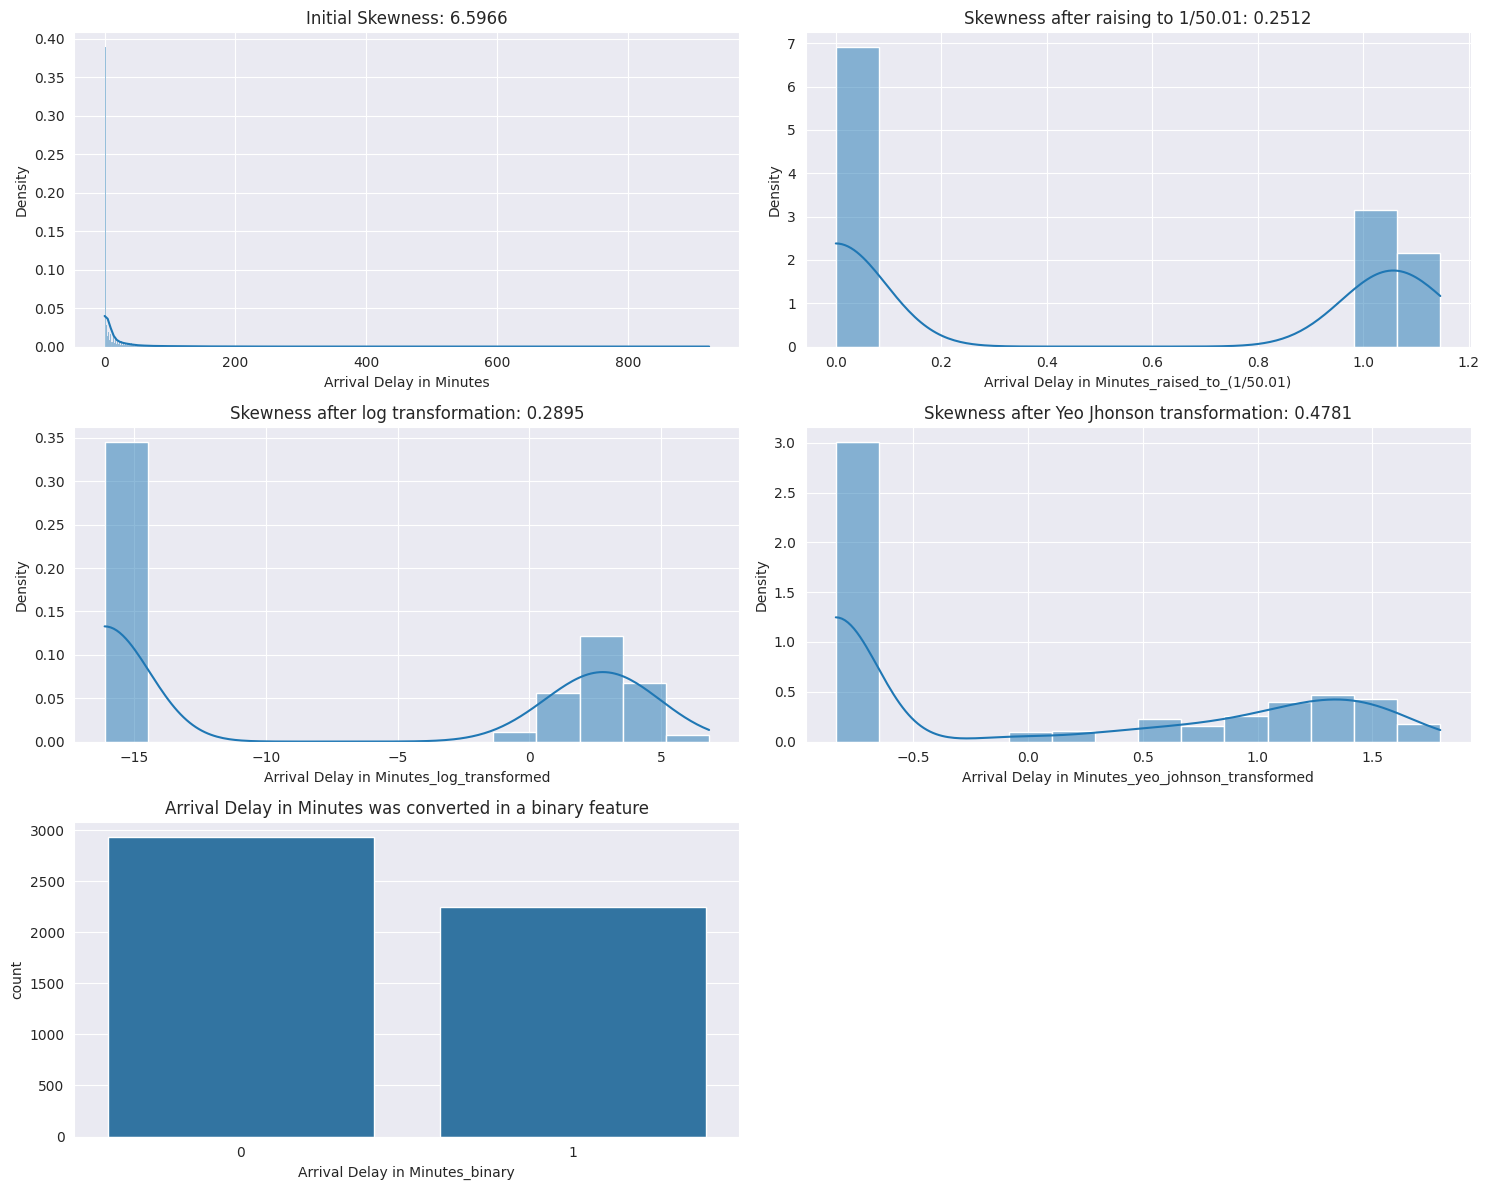

In [188]:
df, x = correct_skew(airline, 'Arrival Delay in Minutes')